In [1]:
# -------------------------
# If you use Google Colab
# -------------------------
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/mavi"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/mavi


In [2]:
import numpy as np 
import jax.numpy as jnp
import jax
from jax import device_put
import torch
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

!pip install memory_profiler
%load_ext memory_profiler

In [5]:
%load_ext autoreload
%autoreload 2
from mavi.vanishing_ideal import VanishingIdeal
from mavi.util.preprocessing import Preprocessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Backend comparison: `jax`, `numpy`, or `pytorch`?
---
***Summary:***

**jax backend is 10x faster**. numpy and torch backends runs in similar speed but torch is more memory taking (even no_grad).



***Issue:***

torch backend is too slow even it's supposed to be using GPU, any bug?

### jax

In [ ]:
X = device_put(jax.random.normal(key, (1000, 10)))
%memit X

peak memory: 1041.96 MiB, increment: 0.12 MiB


In [ ]:
%%time
# no jit
vi = VanishingIdeal()
%memit vi.fit(X, 0.01, method="vca", backend='jax') 

peak memory: 1547.61 MiB, increment: 0.05 MiB
CPU times: user 1.63 s, sys: 220 ms, total: 1.85 s
Wall time: 1.91 s


In [ ]:
%%time
# jit
vi = VanishingIdeal()
%memit vi.fit(X, 0.01, method="vca", backend='jax') 

peak memory: 1536.64 MiB, increment: 0.04 MiB
CPU times: user 1.46 s, sys: 183 ms, total: 1.64 s
Wall time: 1.73 s


### numpy

In [ ]:
X = np.random.randn(1000, 10)
%memit X

peak memory: 968.79 MiB, increment: 0.30 MiB


In [ ]:
%%time
vi = VanishingIdeal()
%memit vi.fit(X, 0.01, method="vca", backend='numpy') 

peak memory: 2310.40 MiB, increment: 774.71 MiB
CPU times: user 27.9 s, sys: 3.23 s, total: 31.2 s
Wall time: 16.4 s


### torch

In [10]:
X = torch.randn(1000,10, requires_grad=False).cuda()
%memit X

peak memory: 2929.30 MiB, increment: 0.02 MiB


In [ ]:
%%time
with torch.no_grad():
    vi = VanishingIdeal()
    %memit vi.fit(X, 0.01, method="vca", backend='torch') 

peak memory: 2973.95 MiB, increment: 13.70 MiB
CPU times: user 16.1 s, sys: 2.09 s, total: 18.2 s
Wall time: 18.2 s


---

## Working with MNIST
***Summary***
- Properly setting $\epsilon$ enables basis computations of MNIST.
- To determin $\epsilon$, Proprosessor is helpful. 
- `vca` works without dimentionality reduction. 
- `grad` requires dimentionality reduction. 

In [6]:
import tensorflow as tf
from tensorflow import keras
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

X = test_images.reshape(test_images.shape[0], -1) / 255.0
X = device_put(X)
print(test_images.shape, X.shape)

(10000, 28, 28) (10000, 784)


----------------------
top 43 components has 90.0 % power
correpsonding range of epsilon is (44.709484, 45.37766) (mean: 45.04357147216797)
----------------------
CPU times: user 39.1 s, sys: 1.22 s, total: 40.3 s
Wall time: 21.1 s


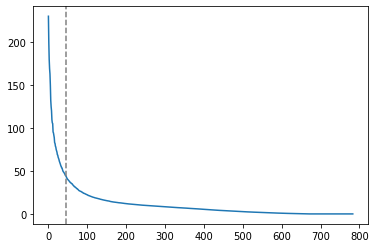

In [9]:
#@title 90% power kept
%%time 
pre = Preprocessor(backend='jax')
Z = pre.fit_transform(X, th=.90, keep_dim=False)

plt.plot(pre.d)
plt.axvline(x=pre.th_id, linestyle='--', color='grey')

In [11]:
## dryrun with small data for jit complilation
vi = VanishingIdeal()
_ = vi.fit(Z[:100], pre.eps, method="vca", backend='jax', max_degree=2) 
_ = vi.fit(Z[:100], pre.eps, method="grad", backend='jax', max_degree=2) 

NameError: ignored

In [15]:
%%time
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="vca", backend='jax') 

peak memory: 4183.25 MiB, increment: 0.05 MiB
CPU times: user 1.13 s, sys: 259 ms, total: 1.39 s
Wall time: 1.51 s


In [16]:
%%time
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="grad", backend='jax') 

peak memory: 4183.25 MiB, increment: 0.00 MiB
CPU times: user 283 ms, sys: 102 ms, total: 385 ms
Wall time: 544 ms


----------------------
top 85 components has 95.0 % power
correpsonding range of epsilon is (25.450928, 25.70967) (mean: 25.580299377441406)
----------------------
CPU times: user 41.2 s, sys: 1.24 s, total: 42.5 s
Wall time: 22.3 s


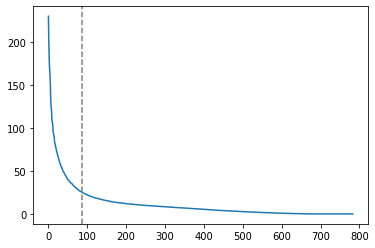

In [10]:
#@title 95% power kept
%%time 
pre = Preprocessor(backend='jax')
Z = pre.fit_transform(X, th=.95, keep_dim=False)

plt.plot(pre.d)
plt.axvline(x=pre.th_id, linestyle='--', color='grey')

In [25]:
%%time
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="vca", backend='jax') 

peak memory: 4191.76 MiB, increment: 0.06 MiB
CPU times: user 15.5 s, sys: 7.54 s, total: 23.1 s
Wall time: 24.3 s


In [26]:
%%time
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="grad", backend='jax') 

peak memory: 4192.02 MiB, increment: 0.23 MiB
CPU times: user 2.16 s, sys: 218 ms, total: 2.37 s
Wall time: 3.88 s


----------------------
top 253 components has 99.0% power
correpsonding range of epsilon is (9.751397, 9.816025) (mean: 9.783710479736328)
----------------------
CPU times: user 42.8 s, sys: 1.7 s, total: 44.5 s
Wall time: 24.4 s


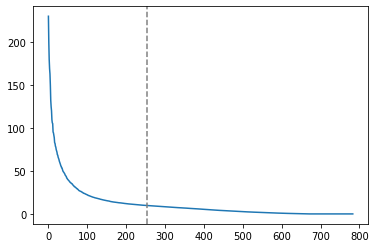

In [16]:
#@title 99% power kept
%%time 
pre = Preprocessor(backend='jax')
Z = pre.fit_transform(X, th=.99, keep_dim=False)

plt.plot(pre.d)
plt.axvline(x=pre.th_id, linestyle='--', color='grey')

In [13]:
%%time
'''
Get Out of Memory error
'''
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="vca", backend='jax') 

RuntimeError: ignored

In [14]:
%%time
'''
Get Out of Memory error
'''
vi = VanishingIdeal()
%memit vi.fit(Z, pre.eps, method="grad", backend='jax') 

RuntimeError: ignored